# 1 - libraries and functions

In [ ]:
# import librairies for deep learning

from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers
from keras.layers import Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from gensim.scripts.glove2word2vec import glove2word2vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from keras import backend as K
from matplotlib import pyplot
from gensim.models import word2vec
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, GRU, Conv1D, GlobalMaxPool1D
from keras.initializers import Constant
# test GloVe model 
from gensim.models import KeyedVectors
import tensorflow_hub as hub
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# print tensorflow version
tf.__version__

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'2.1.0'

In [ ]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# connect to google Drive to import files
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

# 2 - prepare input

## 2.1 - load data

In [ ]:
# load cleaned data set
data="../gdrive/My Drive/colab/twitter_disaster/data/train_processed_data.csv"
df=pd.read_csv(data)
df.dropna(inplace=True)
df.isna().sum()

id              0
text            0
cleaned_text    0
target          0
dtype: int64

## 2.2 - tokenize

In [ ]:
# build tokens
tweets_lines=list()
lines=df['cleaned_text'].values.tolist()
for i in range(len(lines)):
  line=lines[i]
  # print(line)
  tokens=word_tokenize(line)
  tweets_lines.append(tokens)
print('example:')
tweets_lines[0]

example:


['deeds', 'reason', 'earthquake', 'forgive', 'allah']

In [ ]:
# check length of training set
len(tweets_lines)

7612

## 2.3 - generate word embeddings

In [ ]:
## build word2vec embeddings and save it
# define embedding dimension in word2vec: 100 by default
EMBEDDING_DIM=15
model_w2vec = word2vec.Word2Vec(tweets_lines, size=EMBEDDING_DIM, window=20, min_count=7, workers=4)
words=list(model_w2vec.wv.vocab)
print('vocabulary size: %d' % len(words))
# save word2ve embeddings
filename_w2vec = "../gdrive/My Drive/colab/twitter_disaster/twitter_disaster_word2vec.txt"
model_w2vec.wv.save_word2vec_format(filename_w2vec, binary=False)

vocabulary size: 1735


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# load GloVe pre-trained word vectors with gensim 
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '../gdrive/My Drive/colab/twitter_disaster/glove/glove.6B.100d.txt'
# convert GloVe file format to the word2vec format
word2vec_output_file = '../gdrive/My Drive/colab/twitter_disaster/glove/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
# load the Stanford GloVe embeggings
filename_glove = '../gdrive/My Drive/colab/twitter_disaster/glove/glove.6B.100d.txt.word2vec'
model_glove = KeyedVectors.load_word2vec_format(filename_glove, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


KeyboardInterrupt: ignored

In [ ]:
# Extract word embeddings
embeddings_index = dict()
# choose embeddings from w2ve file or glove file
f=open(filename_w2vec)
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1736 word vectors.


In [ ]:
embeddings_index['fire']

array([ 1.0610394 ,  1.2413269 ,  0.37988195,  0.42173666, -1.6955647 ,
        1.1151023 ,  0.26157174, -0.56372374, -0.6167807 ,  0.8138382 ,
        0.6589084 ,  1.114599  ,  1.4408208 ,  0.13970274, -0.42967895],
      dtype=float32)

## 2.4 - convert input for neural network training

In [ ]:
# convert word embedding into tokenized vector
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets_lines)
sequences=tokenizer_obj.texts_to_sequences(tweets_lines)

# pad sequences
tweets=df['cleaned_text'].values
max_length=max([len(s.split()) for s in tweets])
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

tweets_pad = pad_sequences(sequences, maxlen=max_length)
target = df['target'].values
print('shape of tweet tensor:', tweets_pad.shape)
print('shape of target tensor:', target.shape)

Found 11465 unique tokens.
shape of tweet tensor: (7612, 21)
shape of target tensor: (7612,)


In [ ]:
# map embeddings from the loaded word2vec model for each word to the tokenizer_obj.word_index vocabulary and create a matrix with of word vectors.
num_words = len(word_index) + 1
# intiate matrix
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
  if i > num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all zeros
    embedding_matrix[i]=0

# 3 - Training pipeline

## 3.1 - Build model

In [ ]:
from tensorflow import keras

In [ ]:
# define model
model = Sequential()
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length)
model.add(embedding_layer)
model.add(Flatten())

#model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# define optimizers
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# print model summary
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 21, 15)            171990    
_________________________________________________________________
flatten_5 (Flatten)          (None, 315)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 316       
Total params: 172,306
Trainable params: 172,306
Non-trainable params: 0
_________________________________________________________________
None


## 3.2 - splitting training set / validation set

In [ ]:
# split the data into a training set and a validation set
VALIDATION_SPLIT = 0.25
indices =np.arange(tweets_pad.shape[0])
np.random.shuffle(indices)
tweets_pad=tweets_pad[indices]
target=target[indices]
num_validation_samples=int(VALIDATION_SPLIT*tweets_pad.shape[0])

# training set
X_train_pad=tweets_pad[:-num_validation_samples]
y_train=target[:-num_validation_samples]

# validation set
X_test_pad=tweets_pad[-num_validation_samples:]
y_test=target[-num_validation_samples:]

print('shape of X_train_pad tensor:', X_train_pad.shape)
print('shape of y_train tensor:', y_train.shape)

print('shape of X_test_pad tensor:', X_test_pad.shape)
print('shape of y_test tensor:', y_test.shape)

shape of X_train_pad tensor: (5709, 21)
shape of y_train tensor: (5709,)
shape of X_test_pad tensor: (1903, 21)
shape of y_test tensor: (1903,)


In [ ]:
X_test_pad

array([[    0,     0,     0, ...,   263,   936, 10368],
       [    0,     0,     0, ...,   164,   300,   164],
       [    0,     0,     0, ...,   793,  2479, 10041],
       ...,
       [    0,     0,     0, ...,     5,   375,  1488],
       [    0,     0,     0, ...,    28,  8375,  2523],
       [    0,     0,     0, ...,   472,   688,    19]], dtype=int32)

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.

## 3.2 - training model

In [ ]:
# train the classification model
print('Training model...')
history = model.fit(X_train_pad, y_train, batch_size=20, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Training model...
Train on 5709 samples, validate on 1903 samples
Epoch 1/25
5709/5709 - 2s - loss: 0.6320 - accuracy: 0.6523 - val_loss: 0.5470 - val_accuracy: 0.7609
Epoch 2/25
5709/5709 - 1s - loss: 0.4280 - accuracy: 0.8378 - val_loss: 0.4602 - val_accuracy: 0.7882
Epoch 3/25
5709/5709 - 1s - loss: 0.2883 - accuracy: 0.8977 - val_loss: 0.4596 - val_accuracy: 0.7898
Epoch 4/25
5709/5709 - 1s - loss: 0.1998 - accuracy: 0.9345 - val_loss: 0.4764 - val_accuracy: 0.7940
Epoch 5/25
5709/5709 - 1s - loss: 0.1428 - accuracy: 0.9597 - val_loss: 0.5069 - val_accuracy: 0.7861
Epoch 6/25
5709/5709 - 1s - loss: 0.1078 - accuracy: 0.9667 - val_loss: 0.5338 - val_accuracy: 0.7793
Epoch 7/25
5709/5709 - 1s - loss: 0.0855 - accuracy: 0.9728 - val_loss: 0.5615 - val_accuracy: 0.7793
Epoch 8/25
5709/5709 - 1s - loss: 0.0709 - accuracy: 0.9781 - val_loss: 0.5928 - val_accuracy: 0.7677
Epoch 9/25
5709/5709 - 1s - loss: 0.0617 - accuracy: 0.9785 - val_loss: 0.6168 - val_accuracy: 0.7714
Epoch 10/25
5709

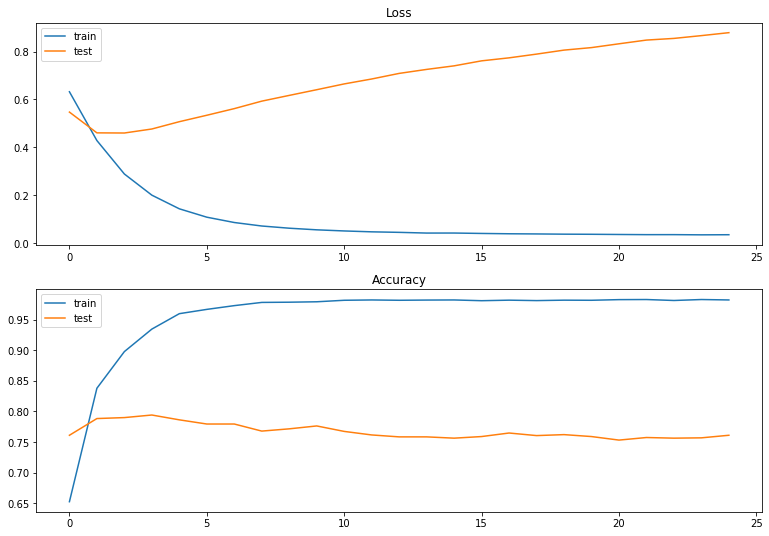

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 9
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9870
Testing Accuracy:  0.7609


In [ ]:
#loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, ytest, verbose=0)

# 4 - validation - performance assessment

In [ ]:
# make predictions transform output to right format
y_pred = model.predict(X_test_pad)
y_pred=y_pred.tolist()
y_pred = [item[0] for item in y_pred]
y_pred=np.array(y_pred)
y_pred

array([7.12330919e-04, 9.99999642e-01, 2.79926389e-01, ...,
       1.14773447e-05, 2.04064374e-04, 9.87583101e-02])

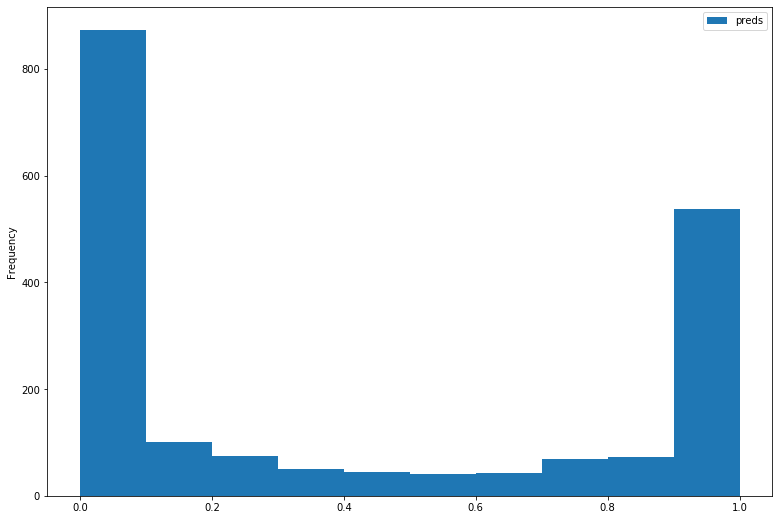

In [ ]:
# plot probabilities distribution
pred = pd.DataFrame(y_pred, columns=['preds'])
pred.plot.hist()

In [ ]:
# round probabilities to get 0 and 1 labels
y_pred_int = y_pred.round().astype('int')

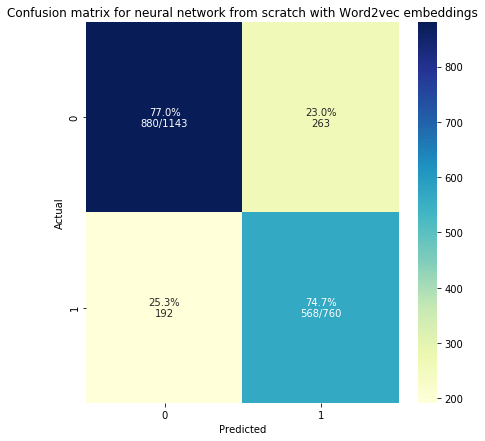

In [ ]:
# Showing Confusion Matrix for BERT model
plot_cm(y_pred_int, y_test, 'Confusion matrix for neural network from scratch with Word2vec embeddings', figsize=(7,7))

# 5 - predictions on unlabelled data

In [ ]:
# load cleaned unlabelled dataset
data="../gdrive/My Drive/colab/twitter_disaster/data/test_processed_data.csv"
df=pd.read_csv(data)
#df.dropna(inplace=True)
df.fillna('-', inplace=True)
df.isna().sum()

id              0
text            0
cleaned_text    0
dtype: int64

In [ ]:
# build tokens
tweets_lines=list()
lines=df['cleaned_text'].values.tolist()
for i in range(len(lines)):
  line=lines[i]
  # print(line)
  tokens=word_tokenize(line)
  tweets_lines.append(tokens)
print('example:')
tweets_lines[0]

example:


['car', 'crash', 'terrible', 'happen']

In [ ]:
len(tweets_lines)

3263

In [ ]:
tweets_pad.shape

(3263, 21)

In [ ]:
# convert word embedding into tokenized vector
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets_lines)
sequences=tokenizer_obj.texts_to_sequences(tweets_lines)

# pad sequences
tweets=df['cleaned_text'].values
max_length=21
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

tweets_pad = pad_sequences(sequences, maxlen=max_length)
#target = df['target'].values
print('shape of tweet tensor:', tweets_pad.shape)

Found 7105 unique tokens.
shape of tweet tensor: (3263, 21)


In [ ]:
# make predictions
y_pred = model.predict(tweets_pad)
y_pred=y_pred.tolist()
y_pred = [item[0] for item in y_pred]
y_pred=np.array(y_pred)
y_pred

array([0.50883663, 0.99999404, 0.9999342 , ..., 0.91844094, 0.07863143,
       0.08595444])

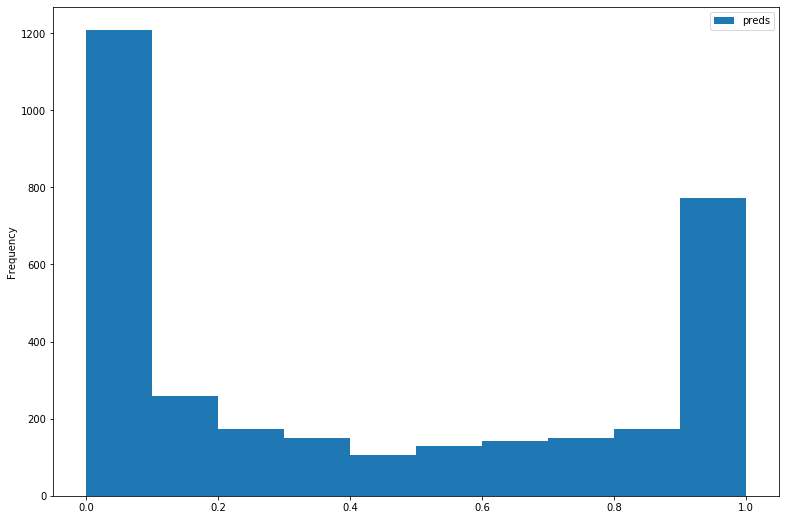

In [ ]:
# plot probabilities distribution
pred = pd.DataFrame(y_pred, columns=['preds'])
pred.plot.hist()

In [ ]:
# round probabilities to get 0 and 1 labels
y_pred_int = y_pred.round().astype('int')

In [ ]:
y_pred_int.shape

(3263,)

In [ ]:
# check predictions
predictions=pd.DataFrame(df['id'])
predictions['target']=y_pred_int
predictions['target'].value_counts()

0    1898
1    1365
Name: target, dtype: int64

In [ ]:
predictions.shape

(3263, 2)

In [ ]:
predictions.to_csv("../gdrive/My Drive/colab/twitter_disaster/submissions/predictions_NN_from_scratch.csv", index=False, header=True)